# import the modules


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot , quarter_plot   
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error , root_mean_squared_error , mean_absolute_percentage_error


## Load the data

In [3]:
# Load the data and aggin the Month with year to the index column
df = pd.read_csv('weekly_customer_complaints.csv' , index_col = 0 , parse_dates = True)
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,"1,750",37.26%,1,0,0
2018-01-08,"1,701",35.38%,0,0,0
2018-01-15,"1,711",36.22%,1,0,0
2018-01-22,"1,443",38.33%,1,0,0
2018-01-29,"1,397",36.34%,0,0,0


## Information about the data frame

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2018-01-01 to 2022-12-26
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaints               261 non-null    object
 1   discount_rate            261 non-null    object
 2   small_commercial_event   261 non-null    int64 
 3   medium_commercial_event  261 non-null    int64 
 4   big_commercial_event     261 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 12.2+ KB


## Data preprocessing

In [10]:
# Remove comma and replace with the float

df['complaints'] = df['complaints'].str.replace(',', '').astype(float)
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,1750.0,37.26%,1,0,0
2018-01-08,1701.0,35.38%,0,0,0
2018-01-15,1711.0,36.22%,1,0,0
2018-01-22,1443.0,38.33%,1,0,0
2018-01-29,1397.0,36.34%,0,0,0


In [11]:
# Setting frequency to W implies that the week start on a Sunday

df = df.asfreq('W-Mon')
df.index

DatetimeIndex(['2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
               '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19',
               '2018-02-26', '2018-03-05',
               ...
               '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14',
               '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12',
               '2022-12-19', '2022-12-26'],
              dtype='datetime64[ns]', name='week', length=261, freq='W-MON')

## Plotting the monthly seasonality

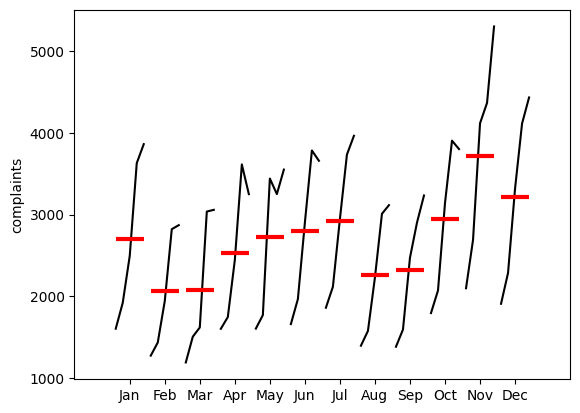

In [12]:
month_plot(df['complaints'].resample('ME').mean(), ylabel = 'complaints')
plt.show()

## Plotting the Quarterly Seasonality

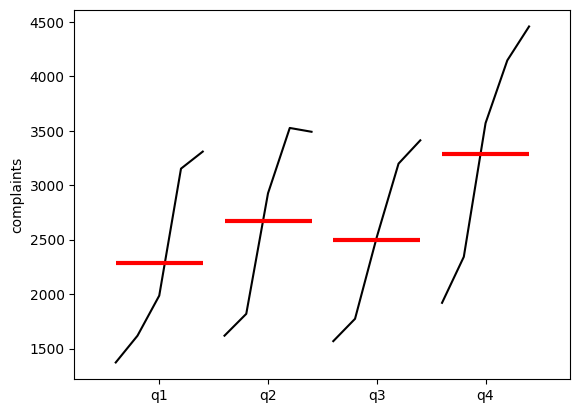

In [13]:
quarter_plot(df['complaints'].resample('QE').mean(), ylabel= 'complaints')
plt.show()

## Seasonal decomposition plots

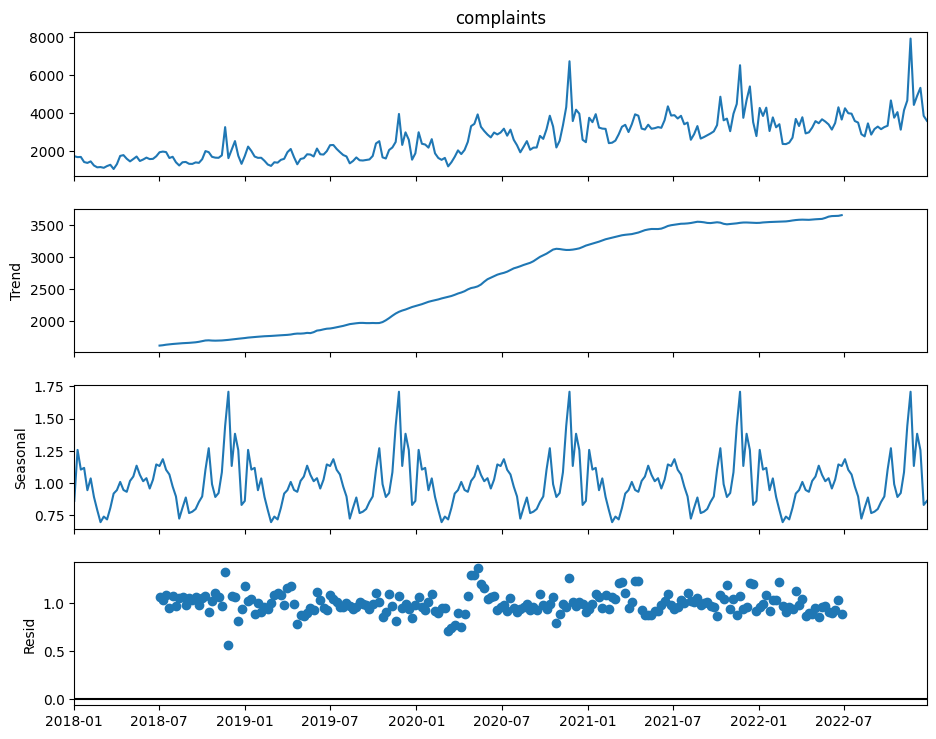

In [14]:
decomposition = seasonal_decompose(df['complaints'], model = 'mul' , period = 52 )
fig= decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

# Auto Correlation

## Plot the auto correlation (ACF)

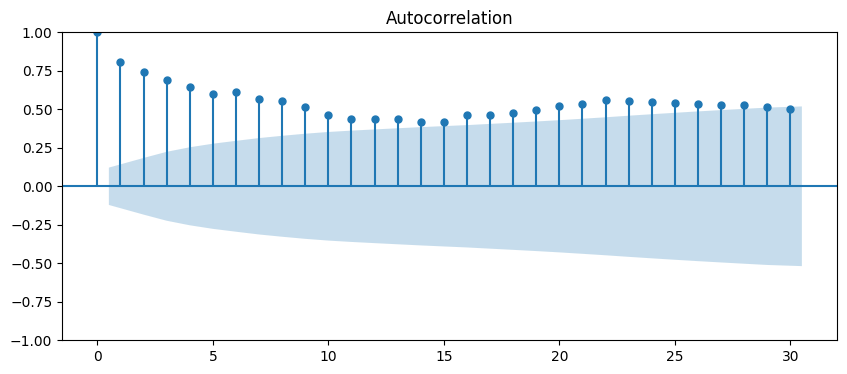

In [15]:
fig , ax = plt.subplots(figsize = (10,4))
plot_acf(df['complaints'], lags = 30 , ax = ax)
plt.show()

## Partial auto correlation

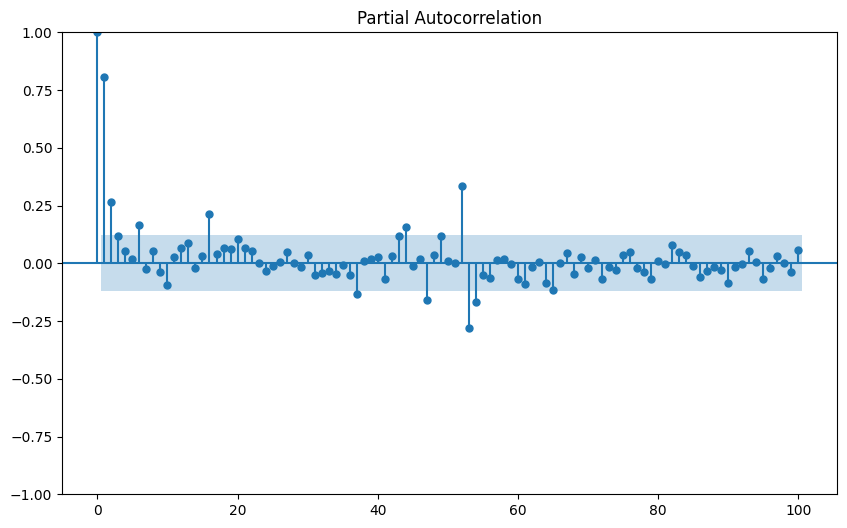

In [16]:
fig , ax = plt.subplots(figsize = (10,6))
plot_pacf(df['complaints'], lags = 100 , ax = ax)
plt.show()

## Training & Test

** Goal : to predict the next quarter (13 weeks)

In [17]:
# Training & test split
periods = 13
train , test =  df.iloc[:-periods,0], df.iloc[-periods:,0]

In [18]:
train.head()

week
2018-01-01    1750.0
2018-01-08    1701.0
2018-01-15    1711.0
2018-01-22    1443.0
2018-01-29    1397.0
Freq: W-MON, Name: complaints, dtype: float64

In [19]:
test.head()

week
2022-10-03    3350.0
2022-10-10    4679.0
2022-10-17    3773.0
2022-10-24    4065.0
2022-10-31    3142.0
Freq: W-MON, Name: complaints, dtype: float64

## Simple Exponential Smoothing

In [26]:
# Simple Exponential Smoothing Model & Prediction
model_simple = SimpleExpSmoothing(train).fit()
predictions_simple = model_simple.forecast(len(test))

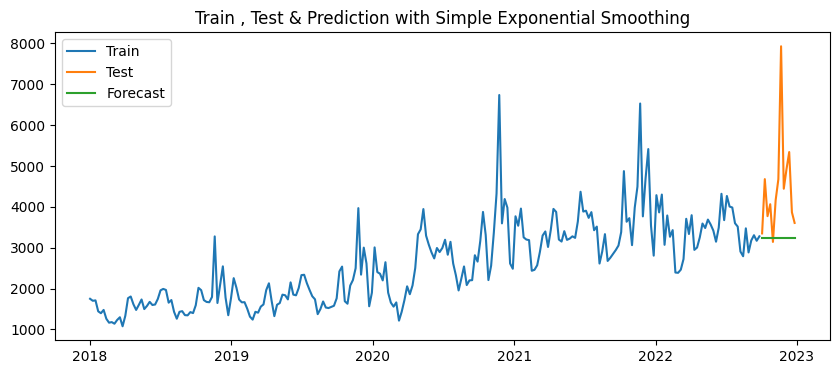

In [35]:
# Plot training , test and forecast
plt.figure(figsize = (10,4))
plt.plot(train, label = 'Train')
plt.plot(test , label = 'Test')
plt.plot(predictions_simple, label = 'Forecast')
plt.title('Train , Test & Prediction with Simple Exponential Smoothing')
plt.legend()
plt.show()

# Double Exponential Smoothing

In [39]:
#Double Exponential Smoothing
model_double = ExponentialSmoothing(train , trend = 'additive' , seasonal = None).fit()
model_double

In [40]:
# Predictions
predictions_double = model_double.forecast(len(test))
predictions_double

2022-10-03    3234.055865
2022-10-10    3232.618089
2022-10-17    3231.180312
2022-10-24    3229.742536
2022-10-31    3228.304760
2022-11-07    3226.866984
2022-11-14    3225.429208
2022-11-21    3223.991432
2022-11-28    3222.553655
2022-12-05    3221.115879
2022-12-12    3219.678103
2022-12-19    3218.240327
2022-12-26    3216.802551
Freq: W-MON, dtype: float64

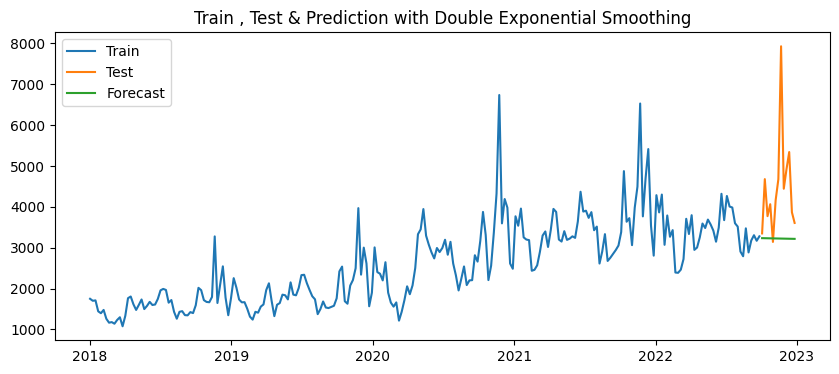

In [41]:
# Plot training , test and forecast
plt.figure(figsize = (10,4))
plt.plot(train, label = 'Train')
plt.plot(test , label = 'Test')
plt.plot(predictions_double, label = 'Forecast')
plt.title('Train , Test & Prediction with Double Exponential Smoothing')
plt.legend()
plt.show()

# Triple Exponential Smoothing (Holt-Winters Method)

In [48]:
#Triple Exponential Smoothing
model_triple = ExponentialSmoothing(train , trend = 'additive' , seasonal = 'mul', seasonal_periods = 52 ).fit()
model_triple

In [49]:
# Predictions
predictions_triple = model_triple.forecast(len(test))
predictions_triple

2022-10-03    4025.154649
2022-10-10    5034.028978
2022-10-17    3914.089402
2022-10-24    3521.043538
2022-10-31    3417.610126
2022-11-07    4227.903516
2022-11-14    5320.009642
2022-11-21    7238.358344
2022-11-28    4315.881938
2022-12-05    5270.594720
2022-12-12    5256.203861
2022-12-19    3416.859773
2022-12-26    3253.257749
Freq: W-MON, dtype: float64

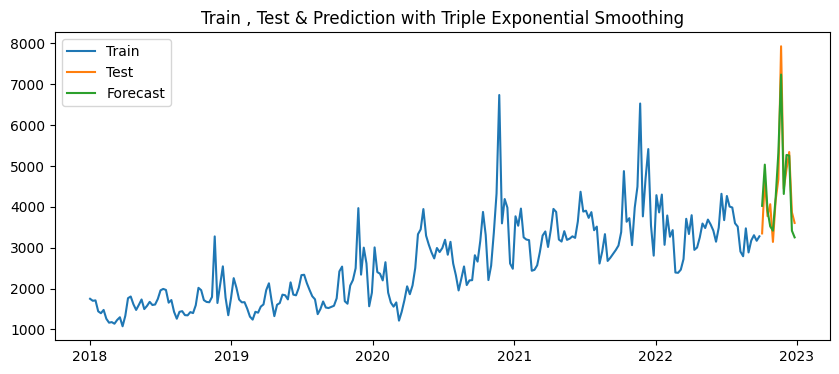

In [50]:
# Plot training , test and forecast
plt.figure(figsize = (10,4))
plt.plot(train, label = 'Train')
plt.plot(test , label = 'Test')
plt.plot(predictions_triple, label = 'Forecast')
plt.title('Train , Test & Prediction with Triple Exponential Smoothing')
plt.legend()
plt.show()

In [67]:
# Calculating MAE, RMSE and MAPE
mae = mean_absolute_error(test, predictions_triple)
rmse = np.sqrt(mean_squared_error(test, predictions_triple))
mape = mean_absolute_percentage_error(test, predictions_triple)

print(f"The MAE is {mae:.2f}")
print(f"The RSME is {rmse:.2f}")
print(f"The MAPE is {100 * mape:.2f}%")

The MAE is 366.14
The RSME is 424.83
The MAPE is 8.52%


## Function to assess model & visualization

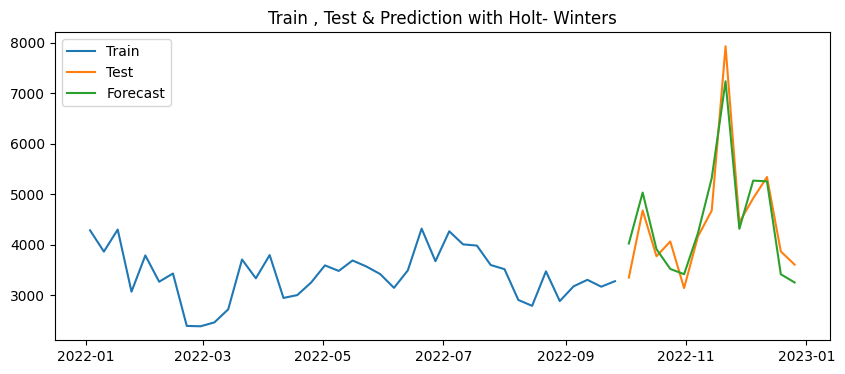

The MAE is 366.14
The RSME is 424.83
The MAPE is 8.52%


In [70]:
def model_assestment (train , test , predictions, chart_title):
    # Plot training , test and forecast
    plt.figure(figsize = (10,4))
    plt.plot(train, label = 'Train')
    plt.plot(test , label = 'Test')
    plt.plot(predictions, label = 'Forecast')
    plt.title(f"Train , Test & Prediction with {chart_title}")
    plt.legend()
    plt.show()

    # Calculating MAE, RMSE and MAPE
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    mape = mean_absolute_percentage_error(test, predictions)
    
    print(f"The MAE is {mae:.2f}")
    print(f"The RSME is {rmse:.2f}")
    print(f"The MAPE is {100 * mape:.2f}%")

model_assestment (train['2022':] , test , predictions_triple, "Holt- Winters")

## Predicting the Future

In [74]:
#Triple Exponential Smoothing
# Get the all data to the prediction as a training data
model = ExponentialSmoothing(df.complaints , trend = 'additive' , seasonal = 'mul', seasonal_periods = 52 ).fit()
model

In [76]:
# Predictions
forecast = model.forecast(13)
forecast

2023-01-02    4830.612817
2023-01-09    4343.461230
2023-01-16    4560.838965
2023-01-23    3690.825069
2023-01-30    4100.542668
2023-02-06    3592.651775
2023-02-13    3263.856291
2023-02-20    2737.202614
2023-02-27    2831.874772
2023-03-06    2897.676110
2023-03-13    3267.533000
2023-03-20    3745.818592
2023-03-27    3605.748068
Freq: W-MON, dtype: float64

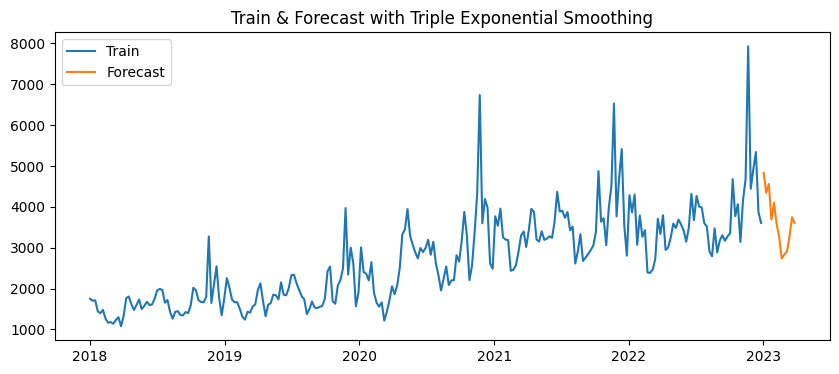

In [77]:
# Plot training and forecast
plt.figure(figsize = (10,4))
plt.plot(df.complaints, label = 'Train')
plt.plot(forecast, label = 'Forecast')
plt.title('Train & Forecast with Triple Exponential Smoothing')
plt.legend()
plt.show()

## Function to plot the future

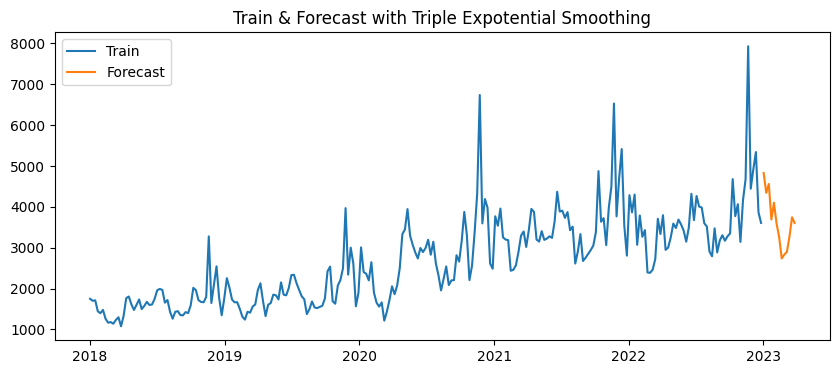

In [80]:
def plot_future (y , forecast , title):
    plt.figure(figsize = (10,4))
    plt.plot(y, label = 'Train')
    plt.plot(forecast, label = 'Forecast')
    plt.title(f'Train & Forecast with {title}')
    plt.legend()
    plt.show()

plot_future (df.complaints , forecast , "Triple Expotential Smoothing")